#### Черненко А.Е. 
### Курсовой проект 
# Image-to-Image Translation with Conditional Adversarial Networks


В курсовом проекте реализован способ преобразования схематичной карты в спутниковый снимок с использованием Conditional Adversarial Networks

Проект создан на основе туториала "Pix2Pix" с сайта tensorflow, в котором данная сеть применялась для генерации изображений зданий на основе схематичных изображеий фасадов. https://www.tensorflow.org/tutorials/generative/pix2pix

## Импорты

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from IPython import display
import time

## Загрузка датасета

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz'

# Загружает файл с URL, если он не уже в кэше.
path_to_zip = tf.keras.utils.get_file('maps.tar.gz',
                                      origin=_URL,
                                      extract=True)

# Путь к директории датасета
PATH = os.path.join(os.path.dirname(path_to_zip), 'maps/')

In [3]:
BUFFER_SIZE = 400  # размер буфера
BATCH_SIZE = 1  # размер пакета
IMG_WIDTH = 256  # ширина одного изображения
IMG_HEIGHT = 256  # высота одного изображения

Исходные изображения в датасете имеют размер 1200 на 600. Эти изображения представляют собой склейки "входного изображения" (карты) и "реального изображения" (соответствующего карте реального спутникового снимка). Пример ниже.

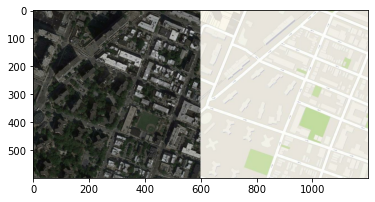

In [4]:
image = tf.io.read_file(PATH+'train/101.jpg')
image = tf.image.decode_jpeg(image)
image = tf.cast(image, tf.float32)
plt.imshow(image/255.)
plt.show()

Функция load преобразует входные изображения в два отдельных набора изображений: карты и реальные спутниковые снимки

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Пример разделения исходного изображения

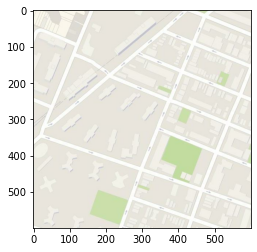

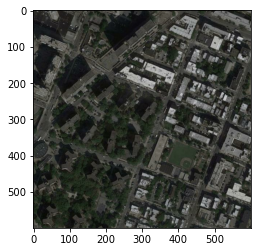

In [6]:
inp, re = load(PATH+'train/101.jpg')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

Функция resize изменяет размер изображений

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

Функция random_crop случайным образом обрезает изображения до размеров IMG_HEIGHT на IMG_WIDTH (у нас 256 на 256)

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

Нормализация изображения к диапазону [-1, 1]

In [9]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

Функция random_jitter: 
* изменение размера изображений на 286 х 286
* случайное обрезание изображений до размера 260 на 260
* с вероятностью "50 на 50" зеркальное отражение изображений слева направо

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Пример

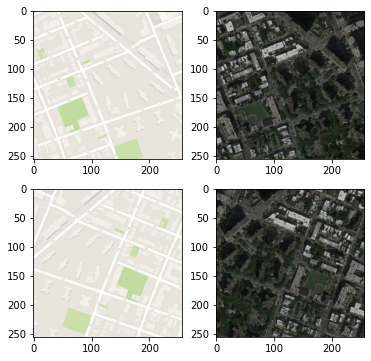

In [11]:
plt.figure(figsize=(6, 6))
for i in range(0,4,2):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.subplot(2, 2, i+2)
  plt.imshow(rj_re/255.0)
plt.show()

Функция подготовки тренировочных данных:
* загрузка
* случайный джиттер
* нормализация

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

Функция подготовки тестовых данных:
* загрузка
* приведение к размеру IMG_HEIGHT на IMG_WIDTH
* нормализация

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Входной пайплайн для подготовки тренировочного и тестового наборов данных

Тренировочные данные читаем из папки train, применяем к ним функцию подготовки load_image_train. Используем буфер фиксированного размера BUFFER_SIZE (у нас 400) для перемешивания элементов. И пакетизируем по BATCH_SIZE (у нас 1) элементов.

In [14]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Тестовые данные читаем из папки val, применяем к ним функцию подготовки load_image_test. И пакетизируем по BATCH_SIZE (у нас 1) элементов.

In [15]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Построение генератора
  * Архитектура генератора - модифицированная U-Net.
  * Каждый блок в кодере (Conv -> Batchnorm -> Leaky ReLU)
  * Каждый блок в декодере (Transposed Conv -> Batchnorm -> Dropout(применяется к первым 3 блокам) -> ReLU)
  * Между кодером и декодером есть пропуск соединений (как в U-Net).

In [16]:
# каналов на выходе
OUTPUT_CHANNELS = 3

Функция создания блока для нисходящего плеча. Параметры:
* количество ядер
* размер ядер
* применять / не применять BatchNormalization

In [17]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Функция создания блока для восходящего плеча. Параметры:
* количество ядер
* размер ядер
* применять / не применять дропаут половины связей

In [18]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Функция построения генератора

In [19]:
def Generator():
  # входной слой
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  # слои нисходящего плеча
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  # слои восходящего плеча
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  # выходной слой
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  #-----------------------------------------------------------------------------
  # СВЯЗЫВНИЕ СЛОЕВ:
   
  # сначала входной слой
  x = inputs

  # связывание слоев по нисходящему плечу
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])  # список выходов с пропущенными соединениями (для конкатенации)

  # Связывание слоев по восходящему плечу с восстановлением пропущенных соединений (где конкатенация)
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  
  # выходной слой
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Посмотрим на схему генератора

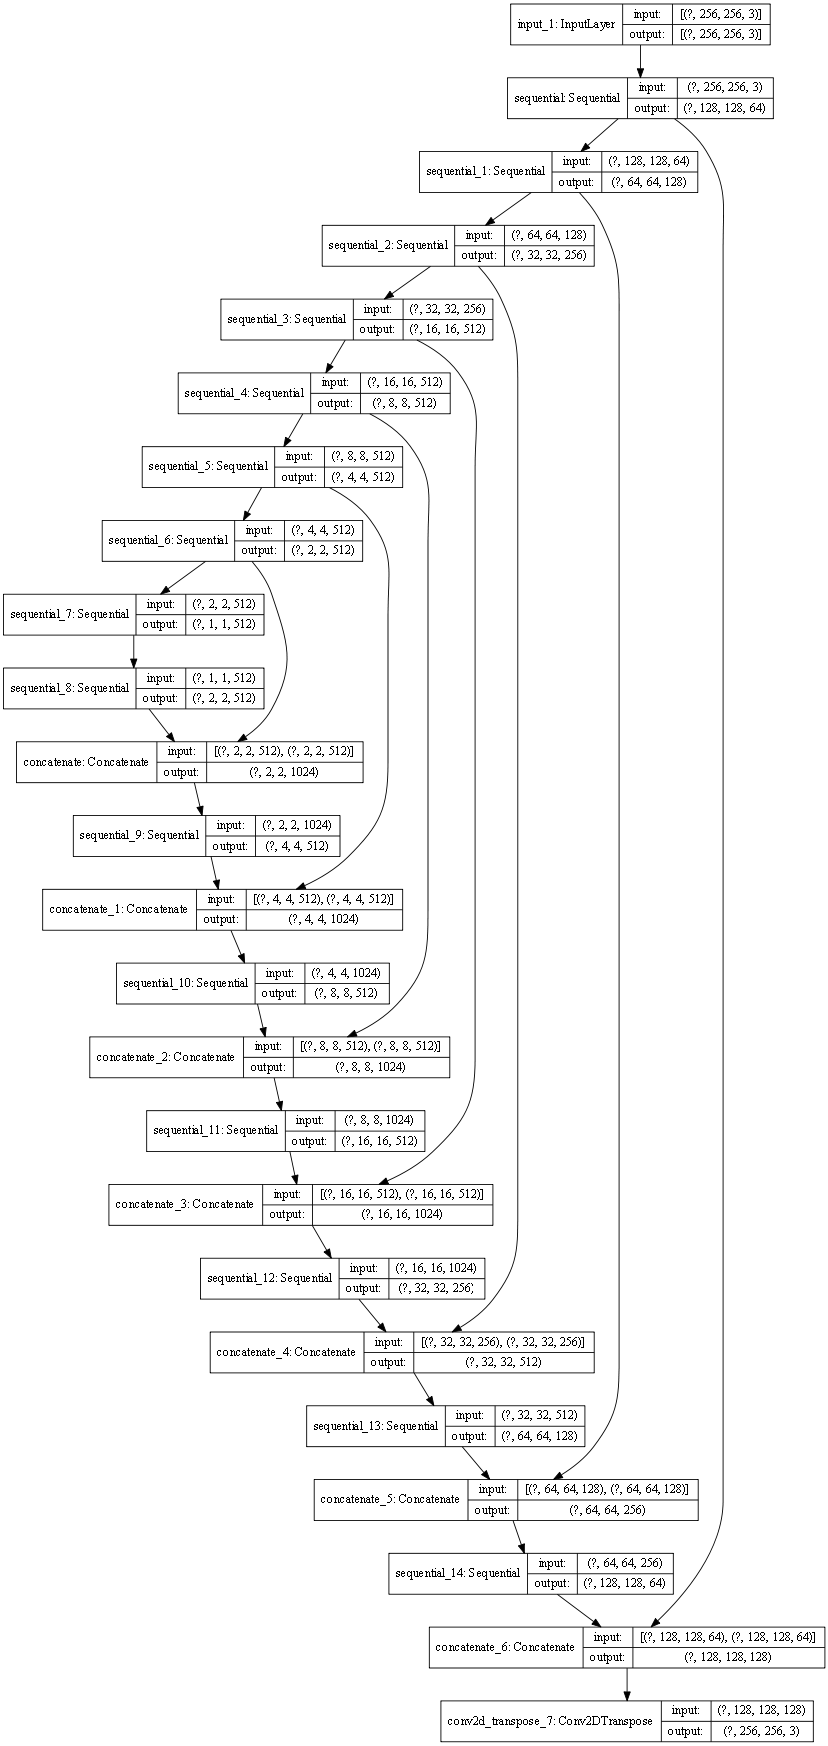

In [20]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Функция потерь генератора
* функция потерь - сигмоидная кросс-энтропия генерируемых изображений и подобных по размерности единичных тензоров.
* Так же включена функция потерь L1, являющаяся MAE (средняя абсолютная ошибка) между генерируемым изображением и целевым изображением. 
* Все это позволяет сгенерированному изображению стать структурно похожим на целевое изображение.
* Формула для расчета суммарных потерь генератора = gan_loss + LAMBDA * l1_loss, где LAMBDA = 100. Это значение было определено авторами оригинальной статьи (https://arxiv.org/pdf/1611.07004.pdf).

In [21]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # MAE
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Процедура обучения для генератора

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Построение дискриминатора
  * Архитектура дискриминатора - PatchGAN.
  * Каждый блок дискриминатора - (Conv -> BatchNorm -> Leaky ReLU)
  * размерность выхода (batch_size, 30, 30, 1)
  * PatchGAN классифицирует каждую NxN часть изображения на предмет True/Fake
  * Дискриминатор принимает 2 входа.
    * Входное изображение и целевое изоражение, которое должно классифицироваться как True.
    * Входное изображение и сгенерированное изображение (выход генератора), которое должно классифицироваться как Fake.
    * Эти два хода объединены с помощью (`tf.concat([inp, tar], axis=-1)`)

In [23]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # Входной слой 1
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  # Входной слой 2
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  # Объединенный входной слой
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  # Добавляем сверточные слои
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Посмотрим схему дисриминатора

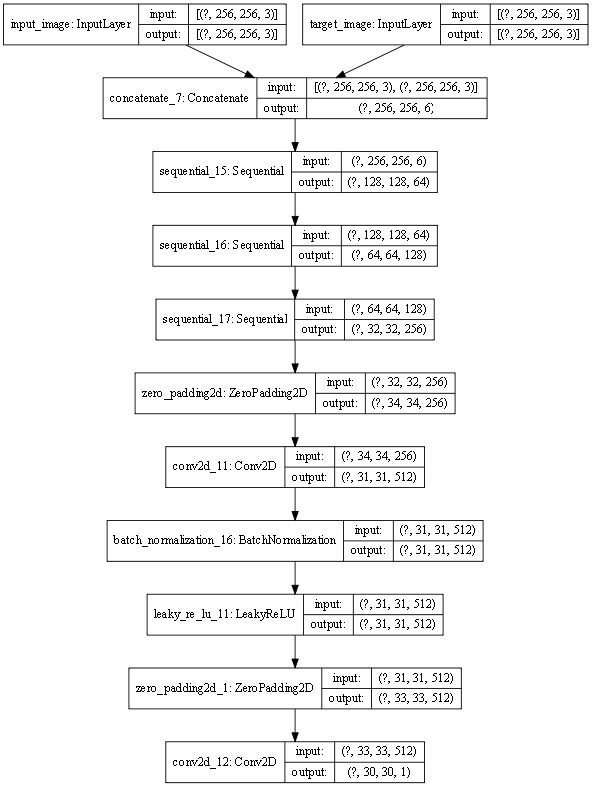

In [24]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Функция потерь дискриминатора


  * Функция потерь дискриминатора имеет 2 входа; **реальные изображения, сгенерированные изображения**
  * real_loss сигмоидная кросс энтропия **реального изображения** и **единичного тензора**
  * generated_loss сигмоидная кросс энтропия **сгенерированного изоражения** and an **нулевого тензора**
  * В конечном итоге total_loss это сумма real_loss и the generated_loss


In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Процедура обучения для дискриминатора

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Оптимизаторы и Checkpoint-saver

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Генерация изображений

* Изображения из тестового набора передаются в генератор.
* Затем генератор преоразует входное изоражение в выходное.
* На последнем шаге оторажается прогноз

In [28]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Входное изображение', 'Реальное изображение', 'Предсказанное изображение']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Обучение

* Для каждого примера входной сигнал генерирует выходной сигнал.
* Дискриминатор получает input_image и сгенерированное изображение в качестве первого входного сигнала. Второй вход - это input_image и target_image.
* Далее расчитываются потери генератора и дискриминатора.
* Затем вычисляются градиенты потерь по отношению как к генератору, так и к дискриминантным переменным(входным сигналам) и применяются к оптимизатору.

In [29]:
EPOCHS = 150

In [30]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

Фактический цикл обучения:

* Перебор числа эпох.
* В каждую эпоху запускается "generate_images", чтобы показать прогресс.
* В каждой эпохе обрабатывается набор обучающих данных, выводится очередная точка для каждого примера.
* Чекпоинт сохраняется каждые 20 эпох.

In [31]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

## Запуск тренирововчного цикла

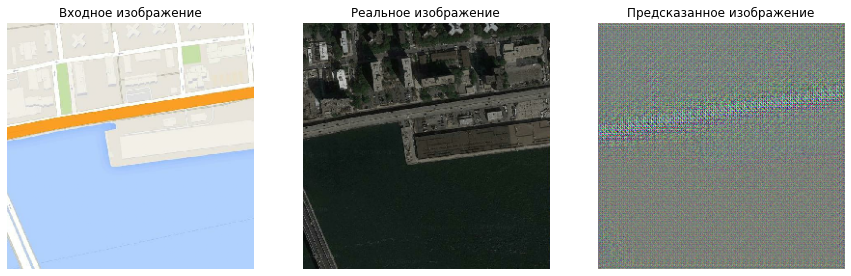

Epoch:  0
...........

In [ ]:
fit(train_dataset, 1, test_dataset)

## Восстановление последнего чекпойнта

In [ ]:
!ls {checkpoint_dir}

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Генерация на тестовых данных

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)